In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [94]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras import layers
from tensorflow import keras
import cv2 as cv


In [3]:
image_size = (224,224)
batch_size = 32

train_ds = image_dataset_from_directory(
    '/content/drive/MyDrive/dataset/training',
    validation_split = 0.2,
    subset = 'training',
    seed = 31,
    image_size = image_size,
    batch_size = batch_size,
)

val_ds = train_ds = image_dataset_from_directory(
    '/content/drive/MyDrive/dataset/training',
    validation_split = 0.2,
    subset = 'validation',
    seed = 31,
    image_size = image_size,
    batch_size = batch_size,
)

Found 3086 files belonging to 2 classes.
Using 2469 files for training.
Found 3086 files belonging to 2 classes.
Using 617 files for validation.


In [4]:
print(train_ds.class_names)

['00-damage', '01-whole']


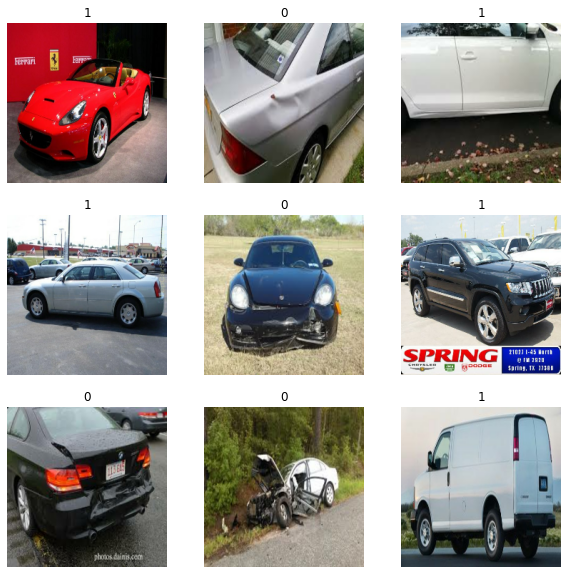

In [5]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [9]:
data_augmentation = keras.Sequential(
    [
     layers.experimental.preprocessing.RandomFlip("horizontal"),
     layers.experimental.preprocessing.RandomRotation(0.1),
     layers.experimental.preprocessing.RandomZoom(0.1),
    ]
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


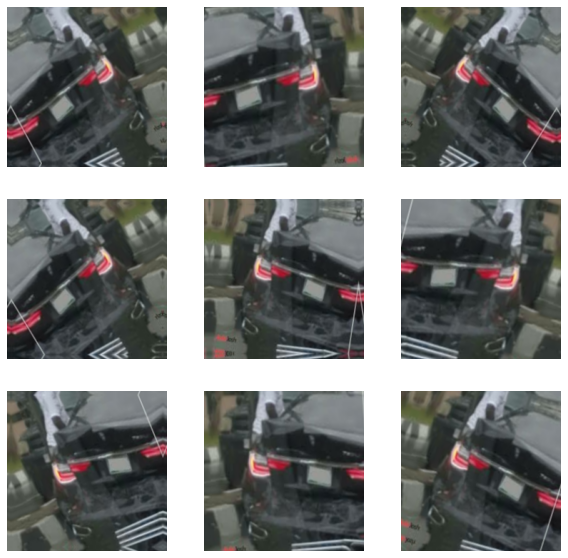

In [10]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(3):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [11]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)


In [42]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


In [50]:
model = make_model(input_shape=image_size + (3,), num_classes=2)

In [ ]:
epochs = 50
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                  patience=5, min_lr=0.001)
model.compile(
    optimizer='adam',
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, validation_data=val_ds, batch_size = 8, callbacks = [reduce_lr]
)

In [48]:
model.evaluate(val_ds)

20/20 [==============================] - 4s 155ms/step - loss: 0.6439 - accuracy: 0.7958


[0.643947422504425, 0.7957860827445984]

In [49]:
model.save('/content/drive/MyDrive/model')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/model/assets


In [52]:
model = keras.models.load_model('/content/drive/MyDrive/model')

In [99]:
def get_prediction(model, path):
  img = cv.imread(path)
  img = cv.resize(img,(224,224))
  img = img.reshape(1,224,224,3)
  proba = model.predict(img)
  return (proba > 0.5).astype('int32')

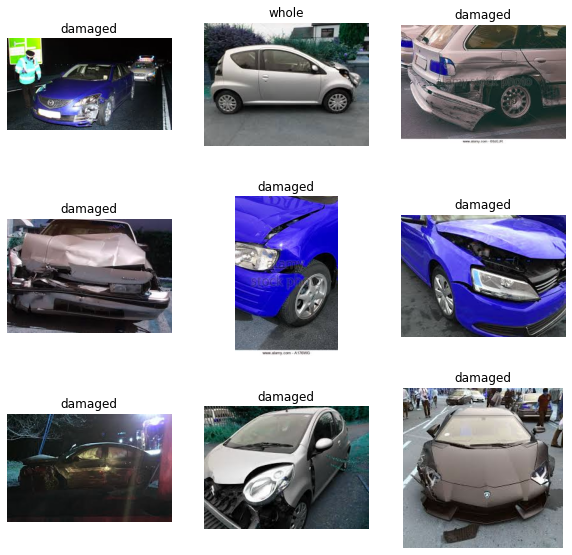

In [102]:
damaged_predictions = []
damaged_images = []
i = 0
for filename in os.listdir('/content/drive/MyDrive/dataset/training/00-damage'):
  abs_path = os.path.join('/content/drive/MyDrive/dataset/training/00-damage', filename)
  image = cv.imread(abs_path)
  prediction = get_prediction(model, abs_path)
  if prediction == 1:
    damaged_predictions.append('whole')
  else:
    damaged_predictions.append('damaged')
  damaged_images.append(image)
  i += 1
  if i == 9:
    break

plt.figure(figsize=(10,10))
for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(damaged_images[i])
      plt.title(damaged_predictions[i])
      plt.axis("off")

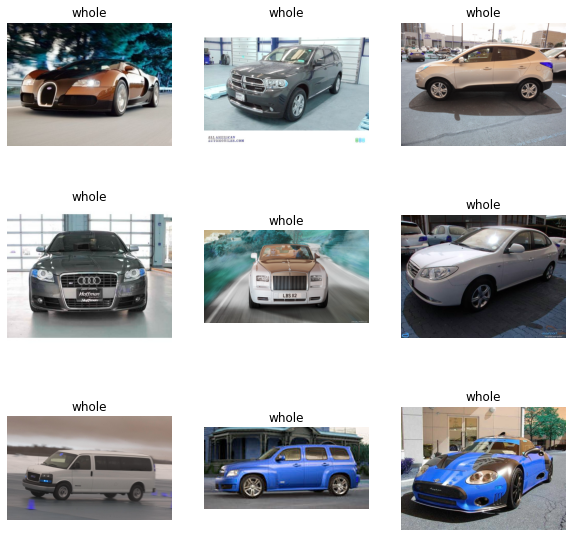

In [107]:
whole_predictions = []
whole_images = []
i = 0
for filename in os.listdir('/content/drive/MyDrive/dataset/training/01-whole'):
  abs_path = os.path.join('/content/drive/MyDrive/dataset/training/01-whole', filename)
  image = cv.imread(abs_path)
  prediction = get_prediction(model, abs_path)
  if prediction == 1:
    whole_predictions.append('whole')
  else:
    whole_predictions.append('damaged')
  whole_images.append(image)
  i += 1
  if i == 9:
    break

plt.figure(figsize=(10,10))
for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(whole_images[i])
      plt.title(whole_predictions[i])
      plt.axis("off")